In [1]:
# Running on GPU?
import setGPU

setGPU: Setting GPU to: 2


# Drift Tubes Digi Occupancy Anomaly Problem with Auto-Encoders

This exercise examines if there is more information about anomalies in occupancy data. Auto-encoder is going to be stacked on top of the previously trained CNN model to spot strange unusual occupancy plots.

* [Data preparation](#Data-preparation)
    * [Visualizing data preparation pipeline](#Visualizing-data-preparation-pipeline)
* [Benchmarks](#Benchmark)
    * [Examples](#Examples-of-voltage-fault)
* [Models](#Models)
    * [Motives for Auto-encoder](#Motives-to-train-Auto-encoder)
    * [Architecture](#Architectures)
    * [Training](#Training)
    * [Snooping](#Data-snooping)
* [Evaluation](#Evaluation)
    * [Spotting voltage problem](#Voltage-fault)
    * [Spotting faulty regions](#Faulty-regions)
    * [Dimensionality reduction](#Dimensionality-reduction)

In [2]:
import math
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt

from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Input, Dense, Flatten, Reshape, Conv2D, UpSampling2D, AveragePooling2D
from keras.layers.advanced_activations import PReLU
from keras.models import Model, load_model
from keras import backend as K
from keras import regularizers

from scipy import misc

from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler
from sklearn.metrics import confusion_matrix, roc_curve, auc

Using TensorFlow backend.


In [3]:
# Change presentation settings

%matplotlib inline

matplotlib.rcParams["figure.figsize"] = (8.0, 5.0)
matplotlib.rcParams["xtick.labelsize"] = 12
matplotlib.rcParams["ytick.labelsize"] = 12
matplotlib.rcParams["axes.spines.left"] = True
matplotlib.rcParams["axes.spines.bottom"] = True
matplotlib.rcParams["axes.spines.right"] = False
matplotlib.rcParams["axes.spines.top"] = False
matplotlib.rcParams["axes.labelsize"] = 14
matplotlib.rcParams["legend.fontsize"] = 14
matplotlib.rcParams["axes.titlesize"] = 14

color_palette = {"Indigo": {
                    50: "#E8EAF6",
                    100: "#C5CAE9",
                    200: "#9FA8DA",
                    300: "#7986CB",
                    400: "#5C6BC0",
                    500: "#3F51B5",
                    600: "#3949AB",
                    700: "#303F9F",
                    800: "#283593",
                    900: "#1A237E"},
                 "Teal": {      
                    50: "#E0F2F1",
                    100: "#B2DFDB",
                    200: "#80CBC4",
                    300: "#4DB6AC",
                    400: "#26A69A",
                    500: "#009688",
                    600: "#00897B",
                    700: "#00796B",
                    800: "#00695C",
                    900: "#004D40"}
                }

line_styles = [(0, ()), (0, (1, 3)), (0, (3, 2))]

In [4]:
# Define those yourself if you want to use your own data

#data_directory = "/eos/cms/store/cmst3/group/dehep/adpol/dt/data"
#labels_directory = "/eos/cms/store/cmst3/group/dehep/adpol/dt/data"

data_directory = "../data"
keras_model = "../model_keras/cnn.h5"

## Data preparation

In [5]:
# Load occupancy data to the dataframe

runs = [272011, 272012, 272014, 272017, 272021, 272774, 273158, 273730,
        274388, 274422, 274968, 274969, 275310, 275311, 275847, 275890,
        276244, 276283, 276384, 276582, 276587, 276775, 276776, 276950,
        278509, 278820, 278822, 279694, 279766, 279794, 280018, 281693,
        281727, 281976, 282735, 282814, 284041, 284042, 284043, 284044,
        297411, 297467, 297468, 297469, 297484, 297665, 297666, 297678,
        299000, 300087, 300390, 300391, 300392, 300393, 300395, 300396,
        300397, 300398, 300399, 300497, 300558, 301142, 301383, 301384,
        302031, 302038, 302040, 302041, 302042, 302043, 302350, 302548,
        302634, 302635, 304144, 304737, 304738, 304739, 304740, 305064,
        305081, 306041, 306042, 306049]

test_run = [302634, 302635, 304737, 304738, 304739, 304740]
train_runs = [r for r in runs if r not in test_run]

drift_tubes_layers = pd.DataFrame()
for run in runs:
    print("Loading %s" % run, end="\r")
    path = "%s/%s.json" % (data_directory, run)
    drift_tubes_layers = drift_tubes_layers.append(pd.read_json(path),
                                                   ignore_index=True);
print("Done. Collected %s layers" % drift_tubes_layers.shape[0], end="\r")

In [6]:
# Filter out all runs having less than 50 lumisections worth of statistics

drift_tubes_layers = drift_tubes_layers.query("lumi%400>50")

In [7]:
# Filter out all chambers in MB4

drift_tubes_layers = drift_tubes_layers.query("station<4")

In [8]:
# Transform the string to list

drift_tubes_layers["content"] = drift_tubes_layers["content"].apply(eval)
drift_tubes_layers["content"] = drift_tubes_layers["content"].apply(np.array)

In [9]:
# Use median polling to remove channels with extreme values

SMOOTH_FILTER_SIZE = 3

def median_polling(layer):
    """Smooths layer occupancy using median filter"""
    smooth_layer = []
    for index in range(len(layer) - (SMOOTH_FILTER_SIZE-1)):
        median = np.median(layer[ index : index + SMOOTH_FILTER_SIZE ])
        smooth_layer.append(median)
    return np.array(smooth_layer)

drift_tubes_layers["content_smoothed"] = drift_tubes_layers["content"].apply(median_polling)

In [10]:
# Use bilinear interpolation to resize all the data samples

SAMPLE_SIZE = min(drift_tubes_layers["content_smoothed"].apply(len))

def resize_occupancy(layer):
    """Resizes occupancy to a given size using bilinear interpolation"""
    return misc.imresize(np.array(layer).reshape(1, -1), (1, SAMPLE_SIZE), interp="bilinear", mode="F").reshape(-1)

drift_tubes_layers["content_resized"] = drift_tubes_layers["content_smoothed"].apply(resize_occupancy)

In [11]:
# Evaluate if the layer is faulty using pretrained CNN model.

CNN_MODEL = load_model(keras_model)
SAMPLE_SIZE = 47

def scale_occupancy(layer):
    """Scales the layer to the <0, 1> range"""
    layer = layer.reshape(-1, 1)
    scaler = MaxAbsScaler().fit(layer)
    return scaler.transform(layer).reshape(1, -1)

def score_occupancy(layer):
    """Predicts if layer is faulty or good"""
    layer = resize_occupancy(layer)
    layer = scale_occupancy(layer)
    return np.argmax(CNN_MODEL.predict(layer.reshape(-1, 47)))

drift_tubes_layers["score"] = drift_tubes_layers["content"].apply(score_occupancy)

In [12]:
# Combine per layer data so we have a matrix of size 12x46 corresponding to a chamber data

SAMPLE_SIZE = min(drift_tubes_layers["content_smoothed"].apply(len))
drift_tubes_chambers = pd.DataFrame()

for run in runs:
    for wheel in range(-2, 3):
        for station in range(1, 4):
            for sector in range(1, 13):

                chamber = drift_tubes_layers[(drift_tubes_layers.run == run) &
                                             (drift_tubes_layers.wheel == wheel) &
                                             (drift_tubes_layers.station == station) &
                                             (drift_tubes_layers.sector == sector)].sort_values("layer",
                                                                                                ascending=1)
                if not len(chamber):
                    continue

                occupancy_resized = np.concatenate(
                    chamber["content_resized"].values).reshape(-1, SAMPLE_SIZE)

                occupancy_raw = [layer.tolist() for layer in chamber["content"]]
                occupancy_smoothed = [layer.tolist() for layer in chamber["content_smoothed"]]
                
                extended_size_raw = max((len(_) for _ in occupancy_raw))
                extended_size_smoothed = max((len(_) for _ in occupancy_smoothed))

                for index, layer in enumerate(occupancy_raw):
                    layer.extend([np.nan]*(extended_size_raw-len(layer)))
                    occupancy_raw[index] = layer

                for index, layer in enumerate(occupancy_smoothed):
                    layer.extend([np.nan]*(extended_size_smoothed-len(layer)))
                    occupancy_smoothed[index] = layer
                   
                score = sum(chamber.score.values)

                data = {"run": run,
                        "wheel": wheel,
                        "station": station,
                        "sector": sector,
                        "score": score,
                        "content_resized": occupancy_resized,
                        "content_smoothed": np.reshape(occupancy_smoothed,
                                                       (len(chamber), extended_size_smoothed)),
                        "content_raw": np.reshape(occupancy_raw,
                                                  (len(chamber), extended_size_raw))}

                drift_tubes_chambers = drift_tubes_chambers.append(pd.Series(data),
                                                                   ignore_index=True)

In [13]:
# Scale the data

def scale_chamber(hits_array):
    """Sales hits by a given scaler."""
    scaler = MinMaxScaler(feature_range=(0, 1)).fit(hits_array.reshape(-1, 1))
    return pd.Series({"content_resized": scaler.transform(hits_array.reshape(-1, 1)).reshape(-1, SAMPLE_SIZE)})

def scale_dataset(new_column, old_column):
    """Scales the dataset"""
    drift_tubes_chambers[new_column] = drift_tubes_chambers.apply(lambda row: scale_chamber(row[old_column]),
                                                                  axis=1)
scale_dataset("content_scaled", "content_resized")

### Visualizing data preparation pipeline

Here are some examples of one chamber (sample) on every step of data preparation:

In [14]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

def plot_occupancy_hitmap(data, title):
    """Visualizes occupancy hitmap"""
    plt.figure()
    
    ax = plt.gca()
    
    ax.set_yticklabels(["1", "5", "9"])
    ax.set_yticks([0, 4, 8])
    plt.xlabel("Channel")
    plt.ylabel("Layer")
    
    im = ax.imshow(data, interpolation="nearest")
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    
    plt.colorbar(im, cax=cax, ticks=[np.min(np.nan_to_num(data)), np.max(np.nan_to_num(data))])
    plt.title(title, loc="right")   
    plt.show();
    
def get_title(title, show):
    return ("%s Occupancy (Run: %s, W: %s, St: %s, Sec: %s)" % 
            (title, int(show.run), show.wheel, show.station, show.sector))

def visualize_preprocessing(show):
    plot_occupancy_hitmap(show.content_raw, get_title("Raw", show))
    plot_occupancy_hitmap(show.content_smoothed, get_title("Smoothed", show))
    plot_occupancy_hitmap(show.content_resized, get_title("Reshaped", show))
    plot_occupancy_hitmap(show.content_scaled, get_title("Scaled", show))

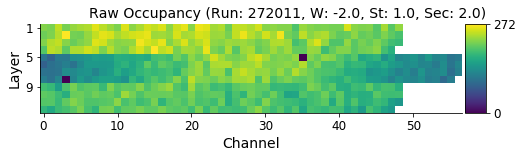

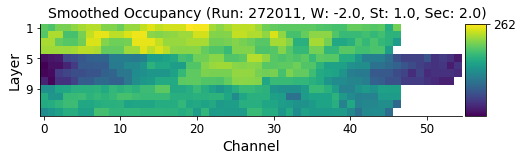

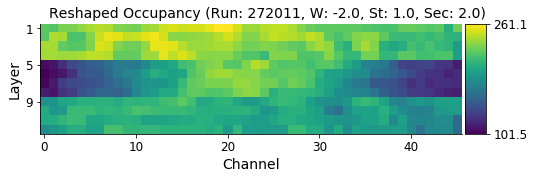

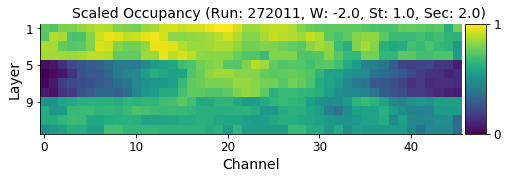

In [15]:
# Chamber without problems
visualize_preprocessing(drift_tubes_chambers[drift_tubes_chambers.score == 0].iloc[0])

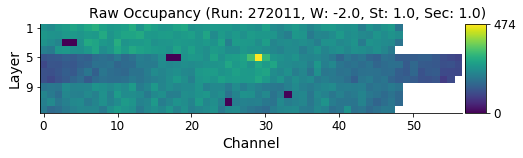

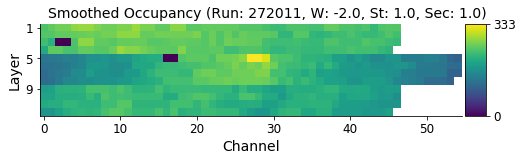

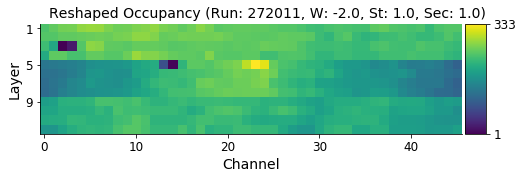

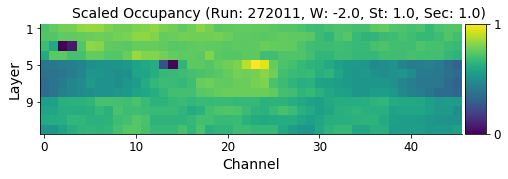

In [16]:
# Chamber with problems
visualize_preprocessing(drift_tubes_chambers[drift_tubes_chambers.score > 0].iloc[0])

## Benchmark

<b>Run 302635</b>: OK<br>
<b>Run 302634</b>: MB4 and MB1 in S3-S4-S5 of WP2, WM2 and W00 have the correct HV<br>
<b>Run 302634</b>: All the other chambers in layer 9 operate at 3200V (almost off)<br>
<b>Runs 304737, 304738, 304739, 304740</b>: All the chambers in layer 9 operate at 3450V (hit efficiency ~70%)

Let's add this information to the dataframe:

In [17]:
drift_tubes_layers.loc[:, "voltage_fault"] = np.nan

# 302634, 304737, 304738, 304739, 304740
drift_tubes_layers.loc[drift_tubes_layers["run"].isin([302634, 304737, 304738, 304739, 304740]),
                       "voltage_fault"] = 1

# 302635
drift_tubes_layers.loc[(drift_tubes_layers["run"] == 302635),  "voltage_fault"] = -1

# 302634
drift_tubes_layers.loc[(drift_tubes_layers["run"] == 302634) &
                       (drift_tubes_layers["station"].isin([1, 4])) &
                       (drift_tubes_layers["sector"].isin([3, 4, 5])) &
                       (drift_tubes_layers["wheel"].isin([-2, 0, 2])), "voltage_fault"] = -1

# If not layer 9
drift_tubes_layers.loc[(drift_tubes_layers["layer"] != 9), "voltage_fault"] = -1

In [18]:
drift_tubes_chambers.loc[:, "voltage_fault"] = np.nan

# 302634, 304737, 304738, 304739, 304740
drift_tubes_chambers.loc[drift_tubes_chambers["run"].isin([302634, 304737, 304738, 304739, 304740]),
                         "voltage_fault"] = 1

# 302635
drift_tubes_chambers.loc[drift_tubes_chambers["run"] == 302635,  "voltage_fault"] = -1

# 302634
drift_tubes_chambers.loc[(drift_tubes_chambers["run"] == 302634) &
                         (drift_tubes_chambers["station"].isin([1, 4])) &
                         (drift_tubes_chambers["sector"].isin([3, 4, 5])) &
                         (drift_tubes_chambers["wheel"].isin([-2, 0, 2])), "voltage_fault"] = -1

In [19]:
# Combine score of CNN model and voltage fault

drift_tubes_chambers["combined_score"] = ((drift_tubes_chambers["voltage_fault"] == 1) | 
                                          (drift_tubes_chambers["score"] > 0))*2-1

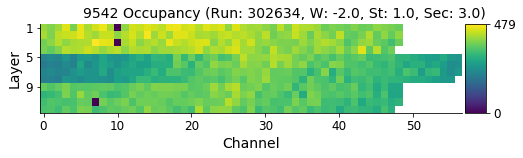

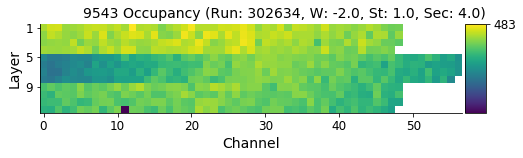

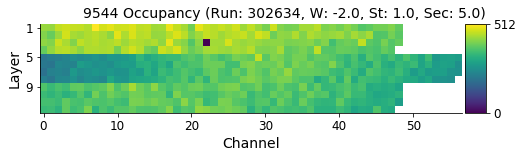

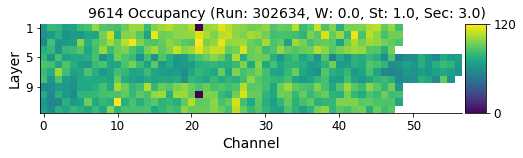

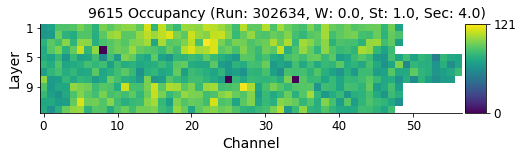

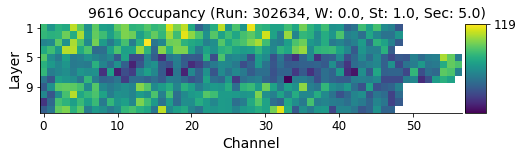

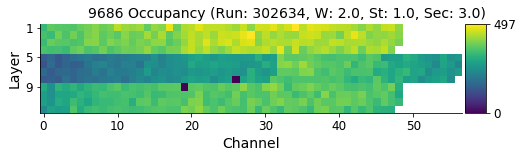

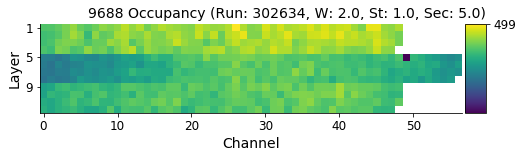

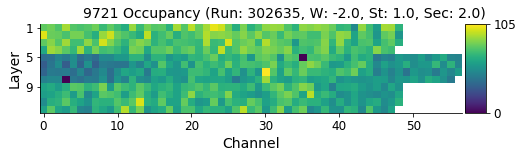

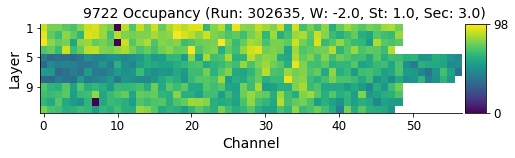

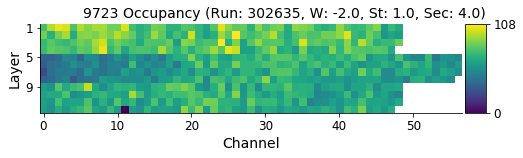

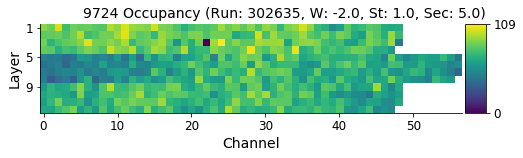

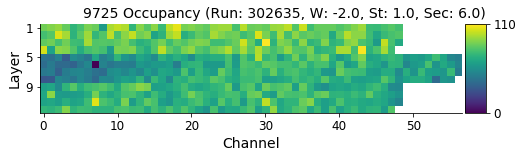

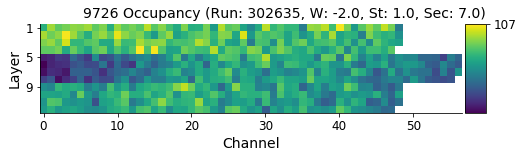

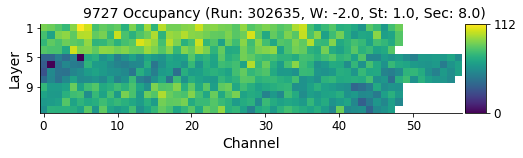

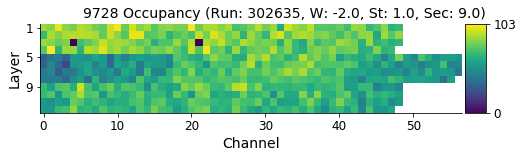

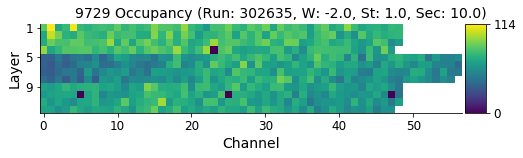

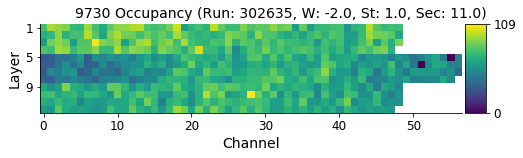

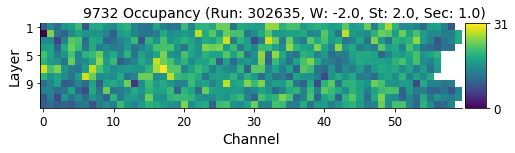

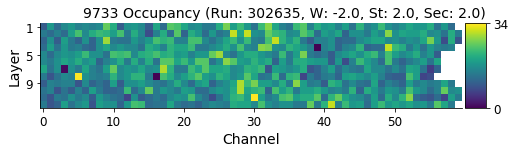

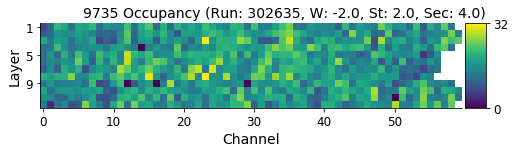

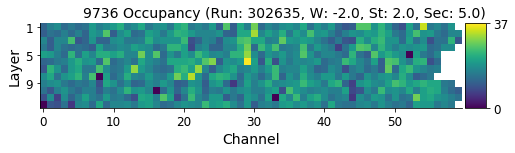

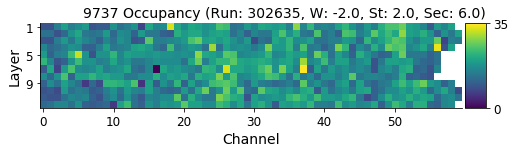

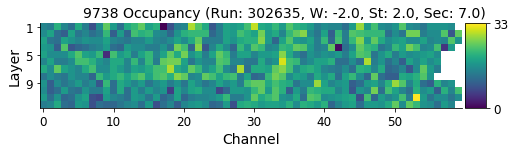

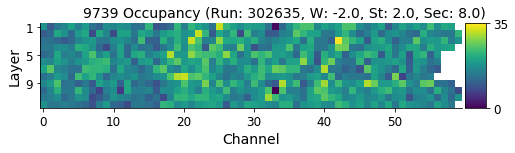

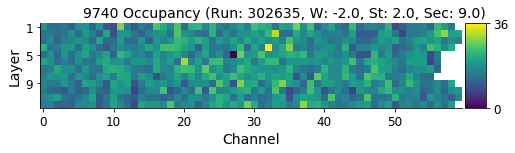

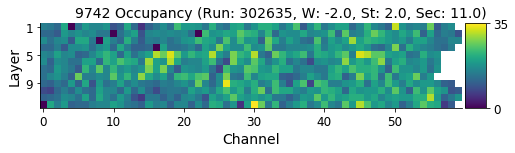

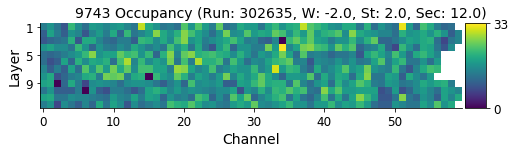

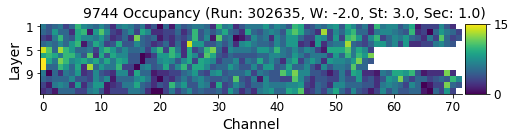

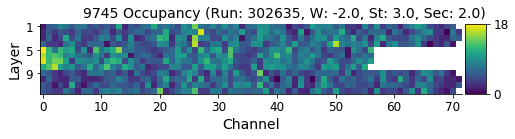

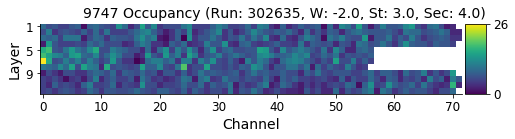

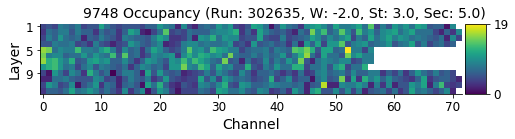

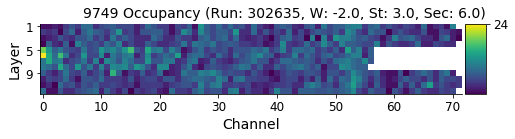

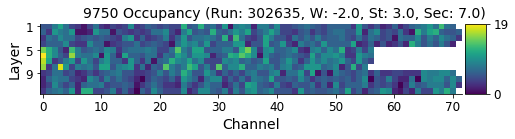

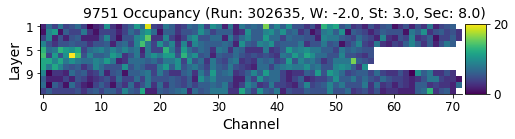

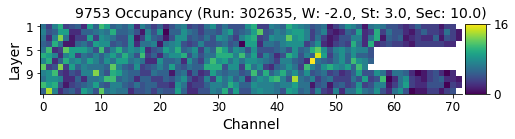

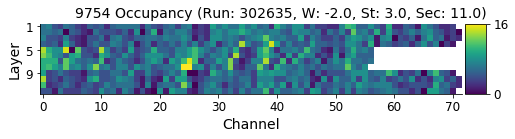

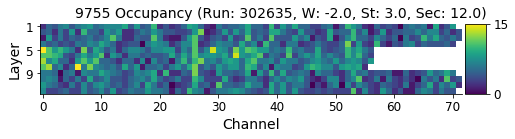

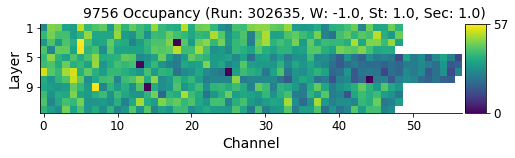

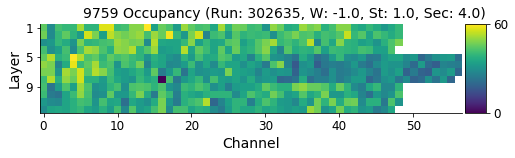

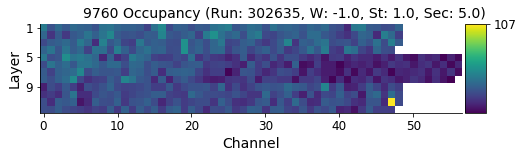

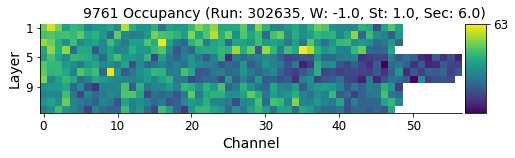

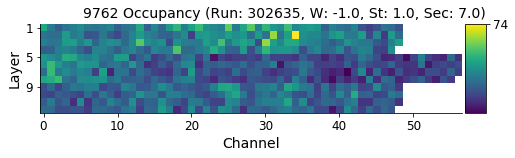

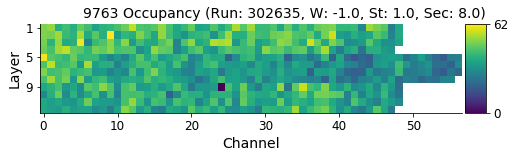

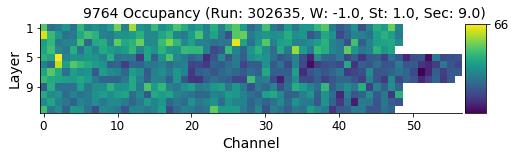

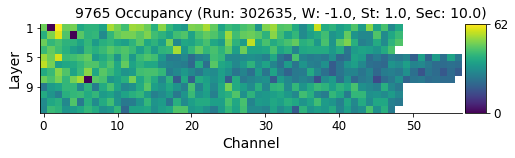

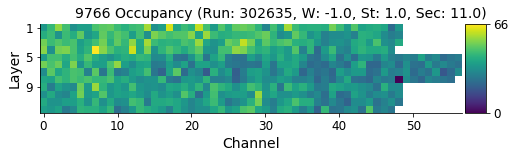

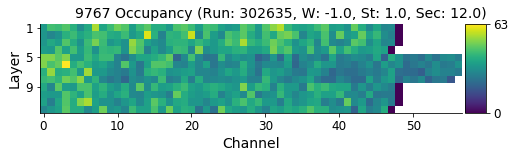

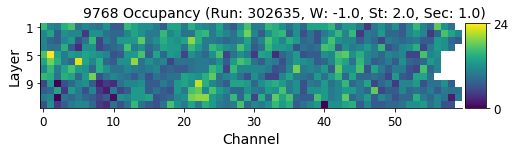

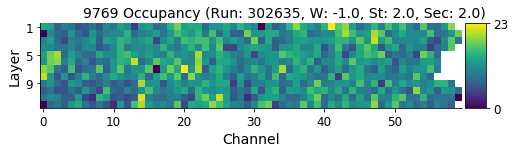

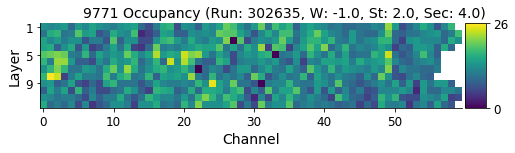

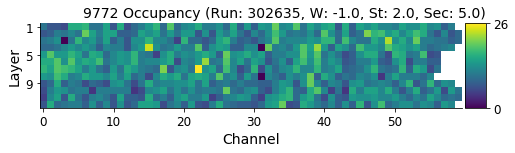

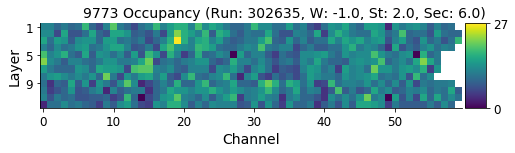

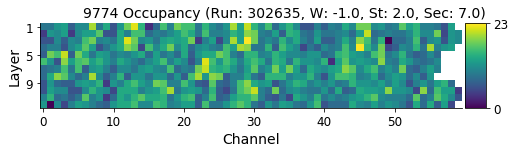

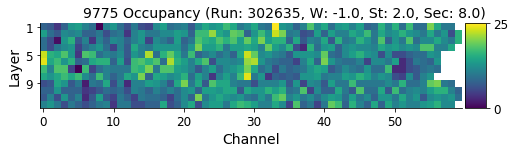

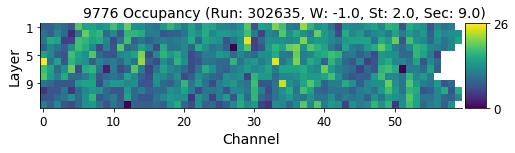

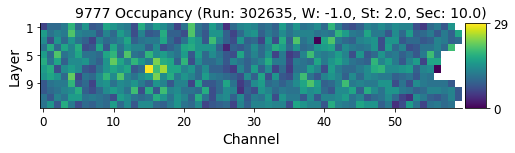

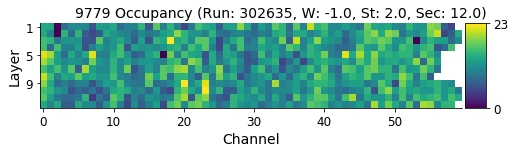

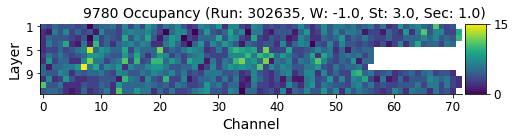

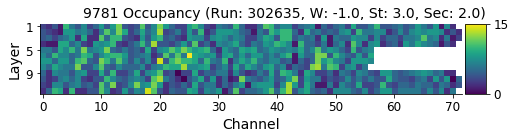

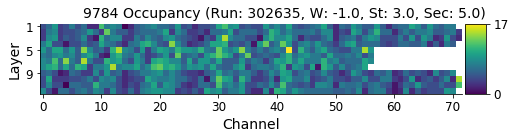

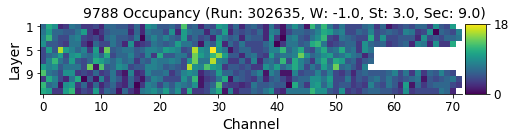

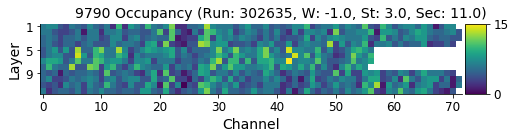

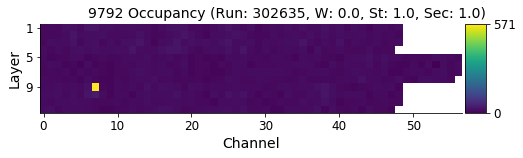

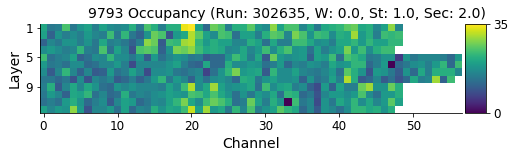

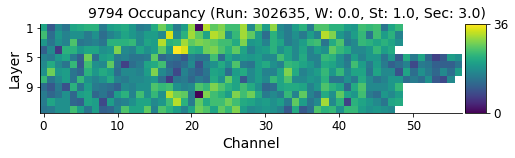

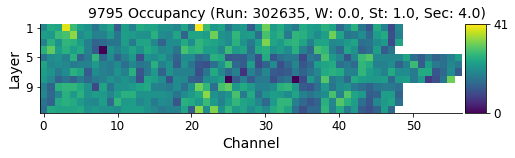

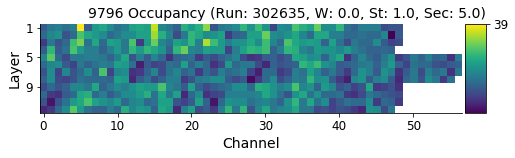

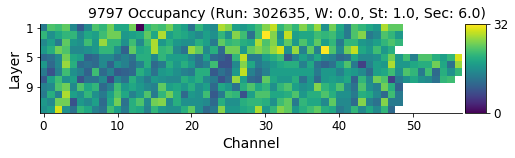

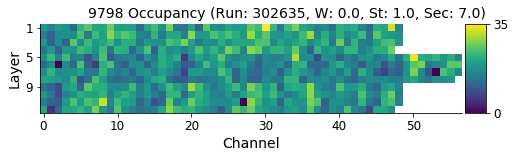

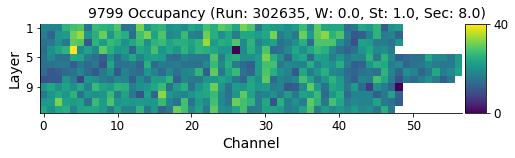

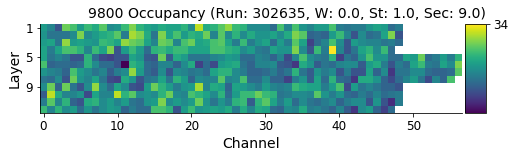

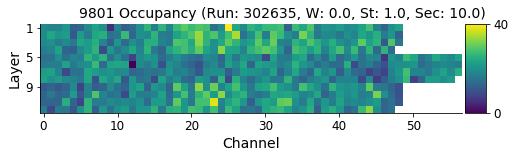

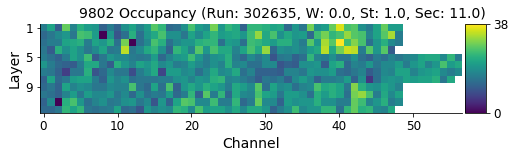

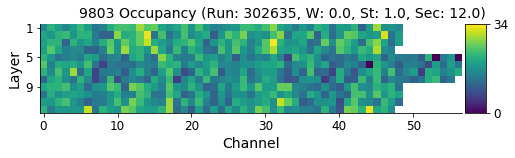

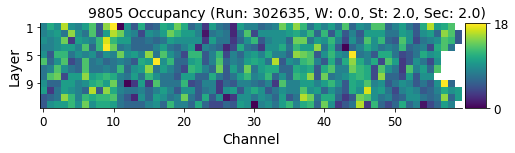

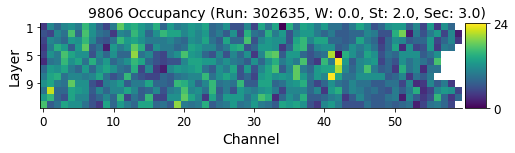

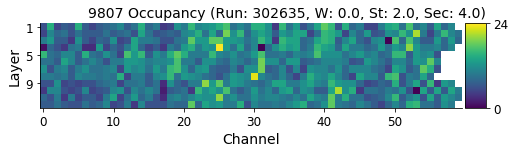

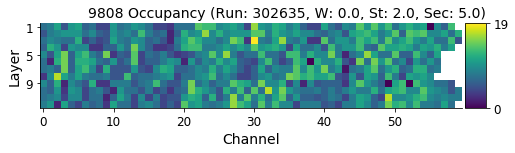

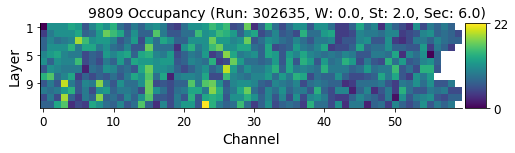

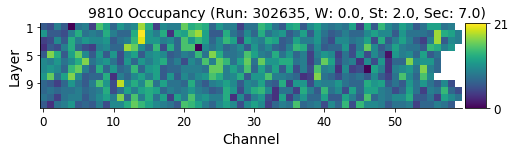

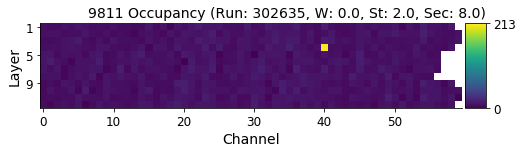

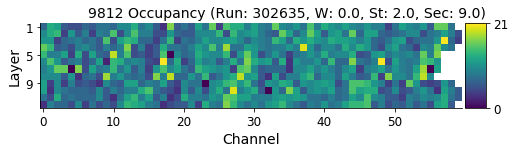

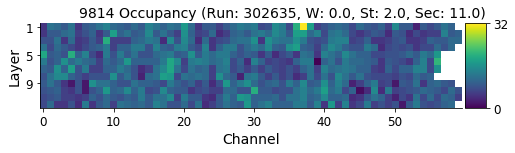

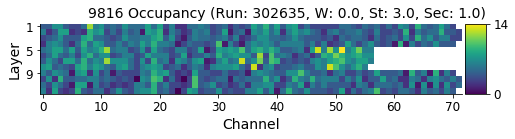

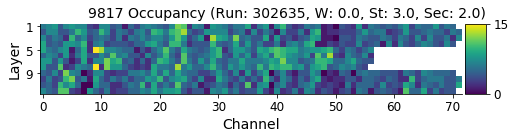

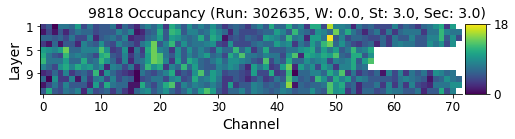

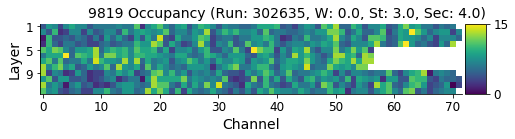

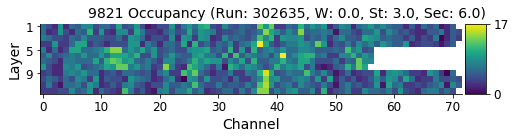

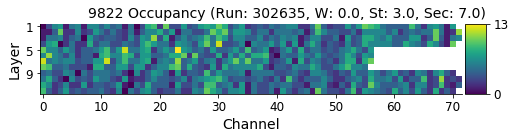

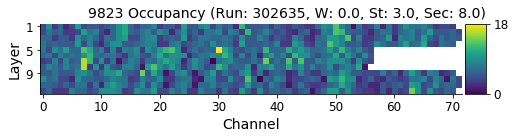

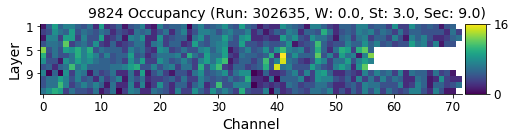

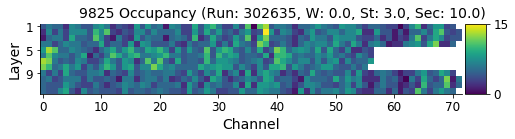

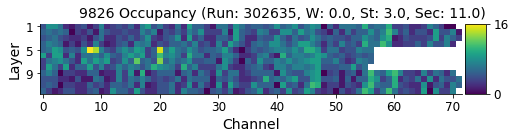

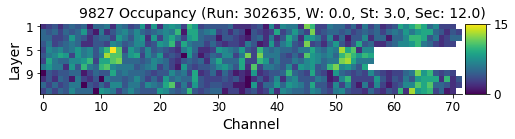

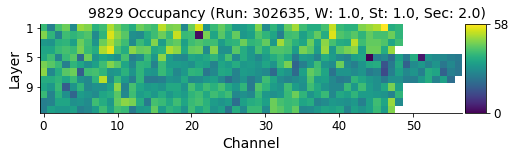

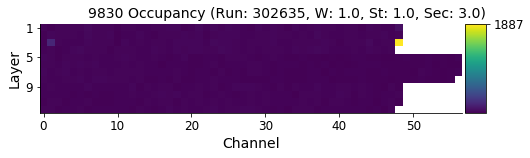

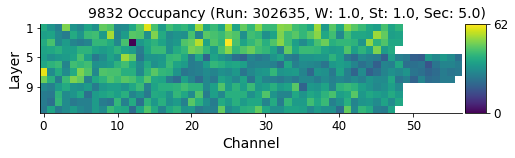

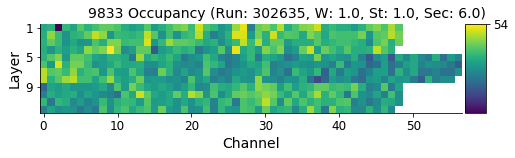

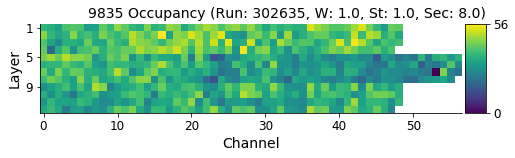

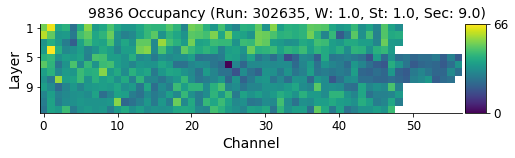

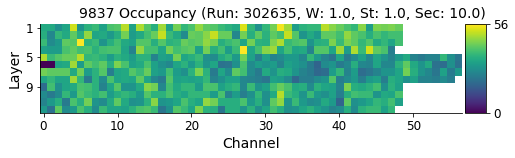

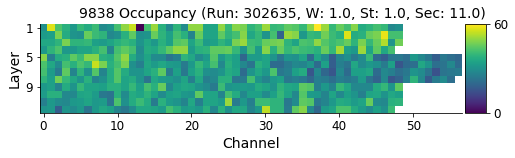

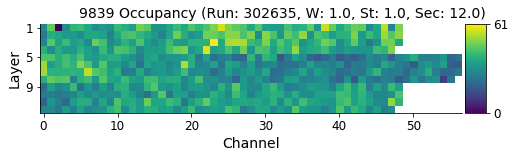

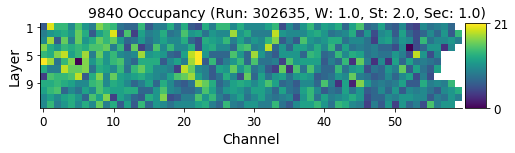

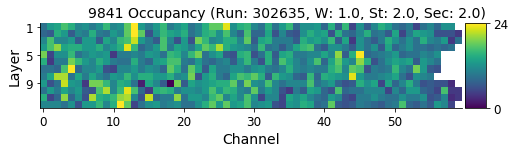

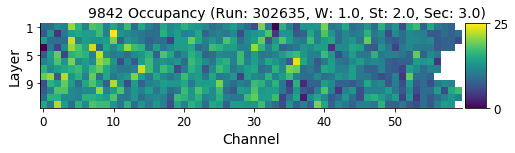

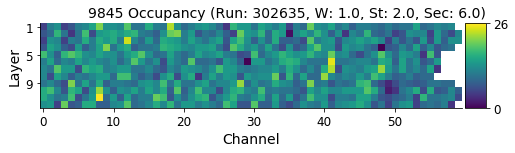

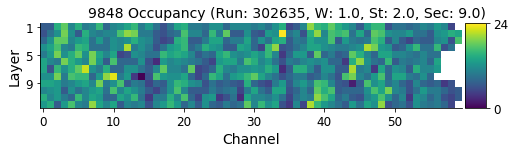

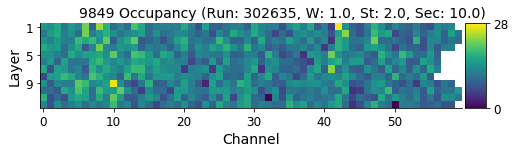

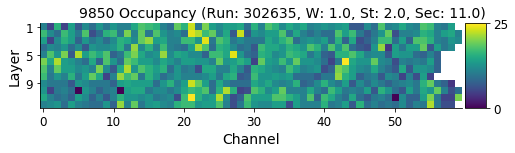

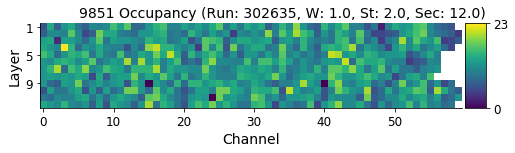

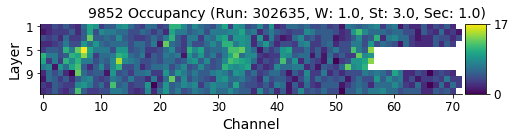

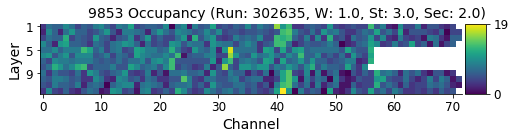

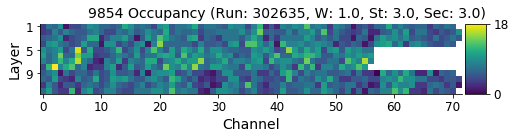

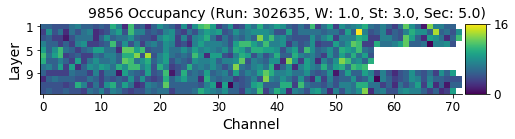

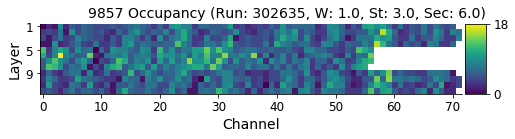

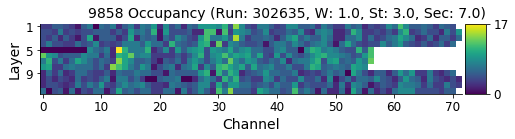

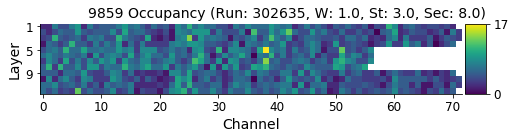

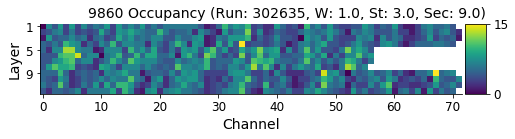

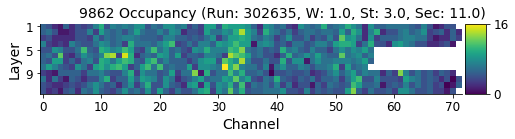

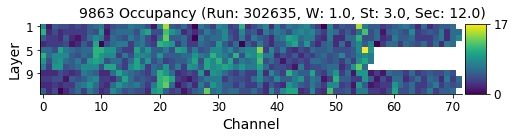

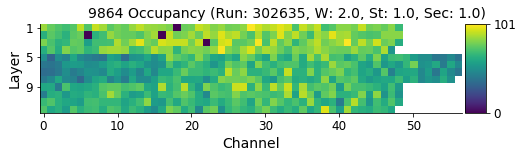

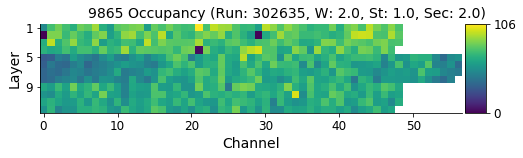

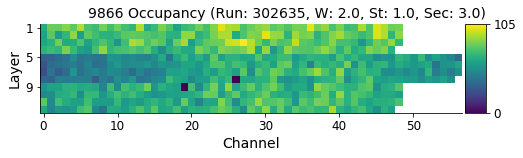

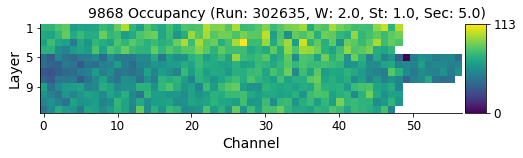

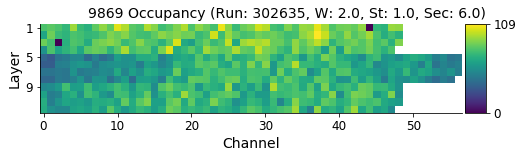

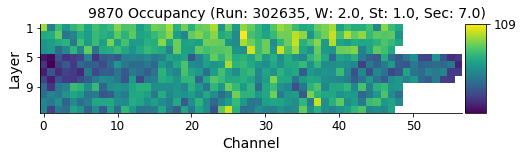

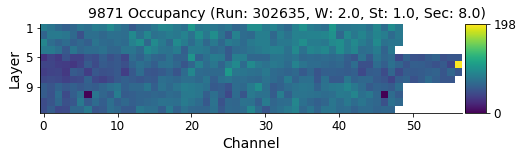

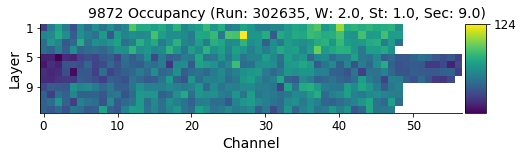

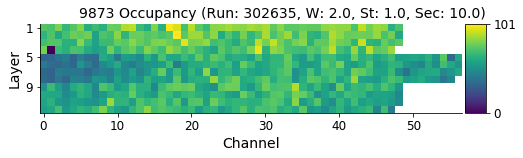

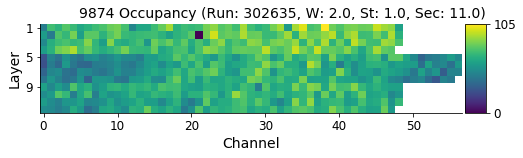

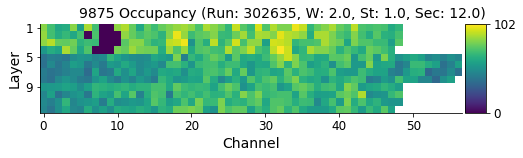

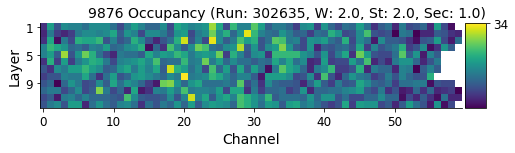

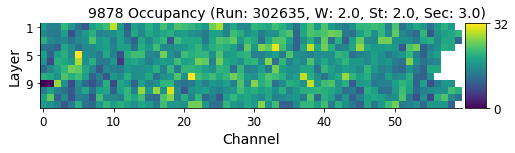

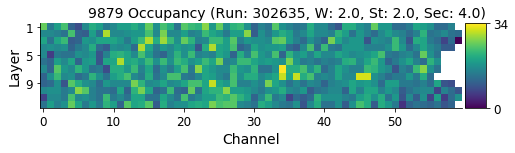

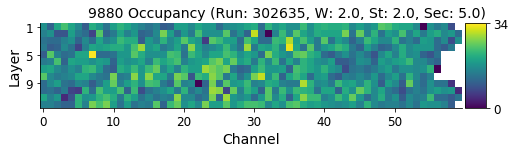

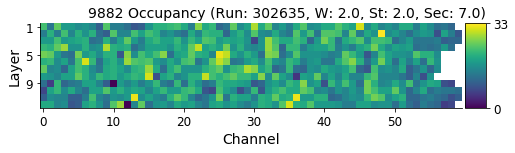

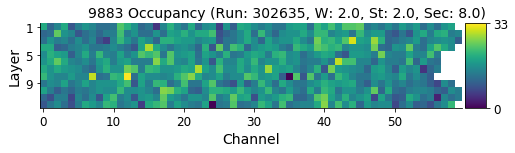

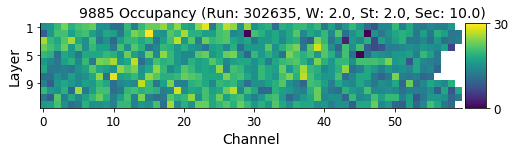

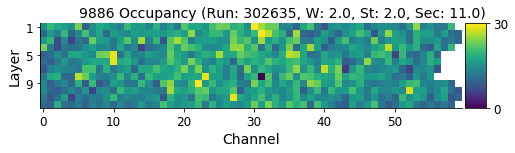

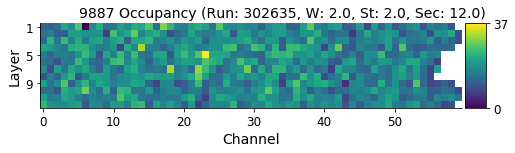

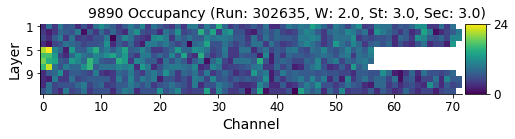

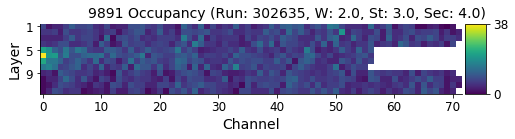

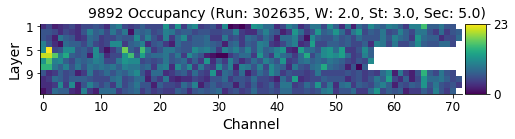

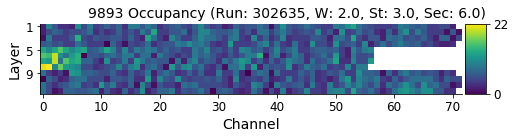

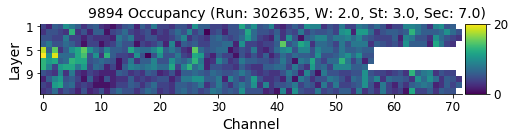

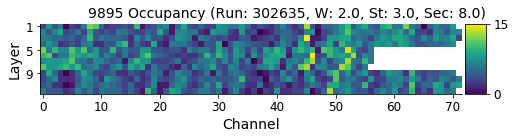

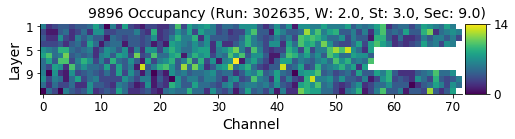

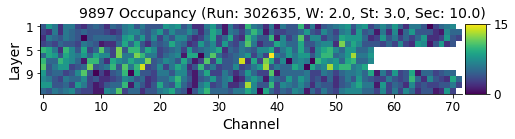

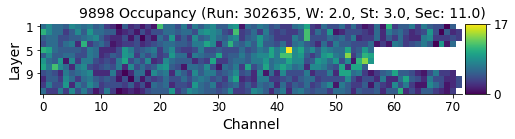

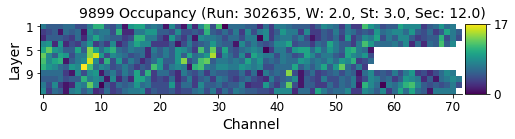

In [20]:
# Visually veryfy score (only claimed as good ones)

for i in drift_tubes_chambers[(drift_tubes_chambers.run.isin(test_run)) &
                              (drift_tubes_chambers.combined_score == -1)].index:
    show = drift_tubes_chambers.loc[i]
    plot_occupancy_hitmap(show.content_raw, get_title("%s" % i, show))

In [21]:
# Make corrections

indexes_to_relabel = [9837, 9858, 9875, 9878]
drift_tubes_chambers.loc[indexes_to_relabel, "combined_score"] = 1

### Examples of voltage fault

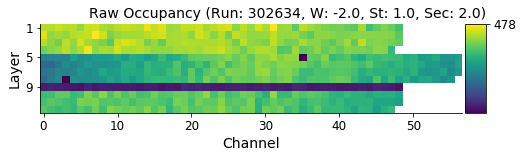

In [22]:
show = drift_tubes_chambers[(drift_tubes_chambers["voltage_fault"] == 1) &
                            (drift_tubes_chambers["score"] == 0)].iloc[0]

plot_occupancy_hitmap(show.content_raw, get_title("Raw", show))

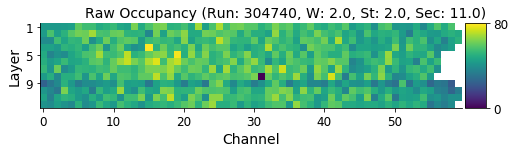

In [23]:
show = drift_tubes_chambers[(drift_tubes_chambers["voltage_fault"] == 1) &
                            (drift_tubes_chambers["score"] == 0)].iloc[-10]

plot_occupancy_hitmap(show.content_raw, get_title("Raw", show))

## Models

### Motives to train Auto-encoder

In [24]:
# This reports how many chambers having a voltage problem have also a dead region

def benchmark(y_true, y_score):
    y_pred = 2*(y_score > 0) - 1
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return round(100*float(tp)/(tp+fn))
    
print("Model sensitivity: %s percent"
      % benchmark(drift_tubes_layers[drift_tubes_layers["run"].isin(test_run)]["voltage_fault"],
                  drift_tubes_layers[drift_tubes_layers["run"].isin(test_run)]["score"]))

Model sensitivity: 6.0 percent


### Architectures

In [25]:
# Slim

_input = Input(shape=(12, 46, 1), name="Input_Image")

x = Flatten(name="Flatten")(_input)
x = Dense(15)(x)
x = PReLU()(x)
x = Dense(3)(x)
encoded = PReLU()(x)

x = Dense(15)(encoded)
x = PReLU()(x)
x = Dense(12*46, name="Flatten2", activation="sigmoid")(x)
decoded = Reshape((12, 46, -1), name='Reshape')(x)

encoder_bottleneck = Model(_input, encoded)
autoencoder_bottleneck = Model(_input, decoded)

In [26]:
bottleneck = 100

In [27]:
# Simple

_input = Input(shape=(12, 46, 1), name="Input_Image")

x = Flatten(name="Flatten")(_input)
x = Dense(bottleneck, name="encoded")(x)
x = PReLU()(x)
x = Dense(12*46, name="Flatten2", activation="sigmoid")(x)
decoded = Reshape((12, 46, -1), name='Reshape')(x)

autoencoder_simple = Model(_input, decoded)

In [28]:
# Convolution

_input = Input(shape=(12, 46, 1), name="Input_Image")

x = Conv2D(4, (4, 4), padding="same", name="Convolution_1")(_input)
x = PReLU(name="Activation_1")(x)
x = AveragePooling2D((4, 4), padding="same", name="Polling_1")(x)
x = Flatten(name="Flatten")(x)
x = Dense(12, name="Dense1")(x)
x = PReLU(name="encoded")(x)
x = Dense(144, name="Flatten2")(x)
x = PReLU()(x)
x = Reshape((3, 12, -1), name="Reshape")(x)
x = UpSampling2D((4, 4))(x)
x = Conv2D(4, (4, 4), padding="same")(x)
x = PReLU()(x)
decoded = Conv2D(1, (1, 3), activation="sigmoid", padding="valid")(x)

autoencoder_convolution = Model(_input, decoded)

In [29]:
# Sparse

sparse = 1e-5

_input = Input(shape=(12, 46, 1), name="Input_Image")

x = Flatten(name="Flatten")(_input)
x = Dense(bottleneck, name="Dense2", kernel_regularizer=regularizers.l1(sparse))(x)
x = PReLU(name="encoded")(x)
x = Dense(12*46, name="Flatten2", kernel_regularizer=regularizers.l1(sparse), activation="sigmoid")(x)
decoded = Reshape((12, 46, -1), name="Reshape")(x)

autoencoder_sparse = Model(_input, decoded)

In [30]:
print("Slim Auto-encoder:")
autoencoder_bottleneck.summary()
print("Simple Auto-encoder:")
autoencoder_simple.summary()
print("Convolution Auto-encoder:")
autoencoder_convolution.summary()
print("Sparse Auto-encoder:")
autoencoder_sparse.summary()

Slim Auto-encoder:
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input_Image (InputLayer)     (None, 12, 46, 1)         0         
_________________________________________________________________
Flatten (Flatten)            (None, 552)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 15)                8295      
_________________________________________________________________
p_re_lu_1 (PReLU)            (None, 15)                15        
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 48        
_________________________________________________________________
p_re_lu_2 (PReLU)            (None, 3)                 3         
_________________________________________________________________
dense_3 (Dense)              (None, 15)                60

## Training

In [31]:
def plot_loss(data, title):
    """Plots the training and validation loss"""
    plt.figure()
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(title)
    plt.plot(data["loss"], linestyle=line_styles[0], color=color_palette["Indigo"][900], linewidth=3)
    plt.plot(data["val_loss"], linestyle=line_styles[2], color=color_palette["Teal"][300], linewidth=3)
    plt.legend(["Train", "Validation"], loc="upper right", frameon=False)
    plt.yscale("log")
    plt.show();

In [32]:
training_matrix = "content_scaled"
optimizer = "adam"
loss = "mse"

train = drift_tubes_chambers[(drift_tubes_chambers["run"].isin(train_runs)) &
                             (drift_tubes_chambers.score == 0)]
x_train = np.concatenate(
    train[training_matrix].values).reshape(-1, 12, SAMPLE_SIZE, 1)
x_test = np.concatenate(
    drift_tubes_chambers[training_matrix].values).reshape(-1, 12, SAMPLE_SIZE, 1)

noise_factor = 0.5
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape)
x_train_noisy = np.clip(x_train_noisy, 0., 1.)

Training ConvAE. All occupancies having one or more problematic layers according to CNN model are excluded.

Training with 8452 samples...


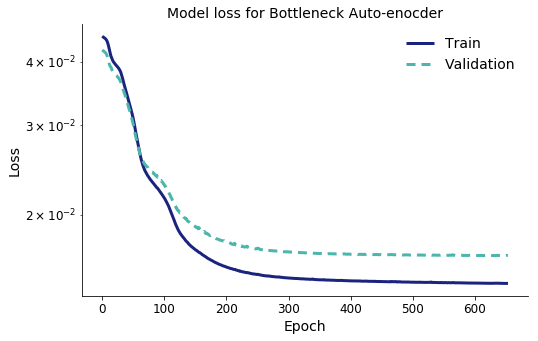

Training with 8452 samples...


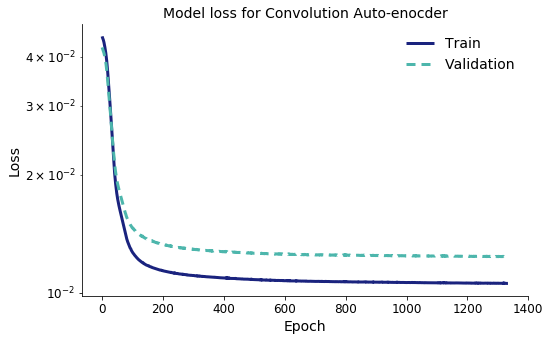

Training with 8452 samples...


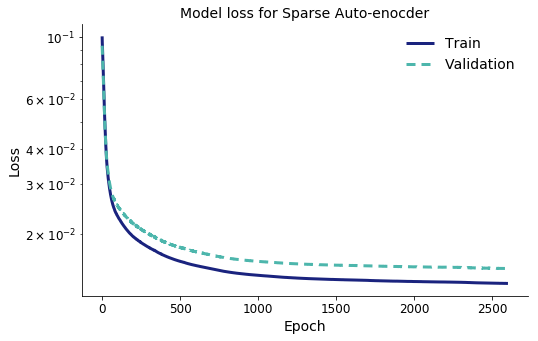

Training with 8452 samples...


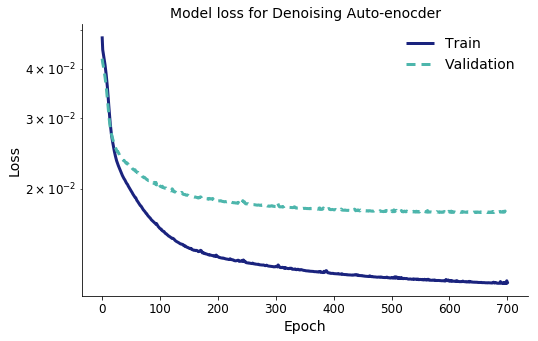

In [33]:
for (autoencoder, name) in [(autoencoder_bottleneck, "Bottleneck"),
                            (autoencoder_convolution, "Convolution"),
                            (autoencoder_sparse, "Sparse"),
                            (autoencoder_simple, "Denoising")]:
    
    if name == "Denoising":
        train_in = x_train_noisy
    else:
        train_in = x_train
        
    print("Compiling the model.", end="\r")

    autoencoder.compile(optimizer=optimizer,
                        loss=loss)

    early_stopper = EarlyStopping(monitor="val_loss",
                                  patience=32,
                                  verbose=False,
                                  mode="auto")
    
    checkpoint_callback = ModelCheckpoint(("../model_keras/%s.h5" % name),
                                          monitor="val_loss",
                                          verbose=False,
                                          save_best_only=True,
                                          mode="min")

    print("Training with %s samples..." % len(train)),

    history = autoencoder.fit(train_in,
                              x_train,
                              epochs=4096,
                              validation_split=0.2,
                              batch_size=int((len(x_train)*0.75)/2),
                              shuffle=True,
                              verbose=False,
                              callbacks=[early_stopper,
                                         checkpoint_callback])
    
    
    plot_loss(history.history, "Model loss for %s Auto-enocder" % name)

In [34]:
autoencoders = ["Bottleneck", "Convolution", "Sparse", "Denoising"]

In [35]:
for name in autoencoders:
    autoencoder = load_model("../model_keras/%s.h5" % name)
    
    score = "score_%s" % name
    decoded = "decoded_%s" % name
    encoded = "encoded_%s" % name
    
    decoded_imgs = autoencoder.predict(x_test).reshape(len(drift_tubes_chambers), 12, SAMPLE_SIZE)
    mse = np.sum(np.sum((x_test.reshape(len(drift_tubes_chambers), 12, SAMPLE_SIZE) - decoded_imgs) ** 2,
                        axis = 1),
                 axis=1)
    
    drift_tubes_chambers.loc[:, score] = mse
    drift_tubes_chambers.loc[:, decoded] = pd.DataFrame(
        {decoded: decoded_imgs.tolist()})
    
    if name == "Bottleneck":
        drift_tubes_chambers.loc[:, encoded] = pd.DataFrame(
            {encoded: encoder_bottleneck.predict(x_test).reshape(-1, 3).tolist()})

### Data snooping

In [36]:
def original_vs_reconstructed(show):
    plot_occupancy_hitmap(show.content_scaled, get_title("Original", show))
    plot_occupancy_hitmap(show.decoded_Denoising, get_title("Reconstructed", show))

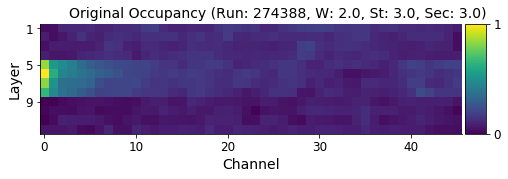

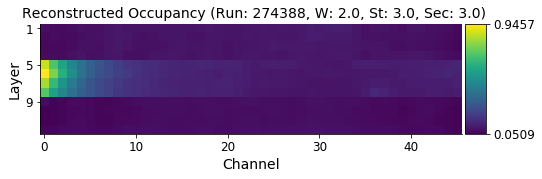

In [37]:
# The best reconstruction
original_vs_reconstructed(drift_tubes_chambers.sort_values('score_Denoising', ascending=1).iloc[0])

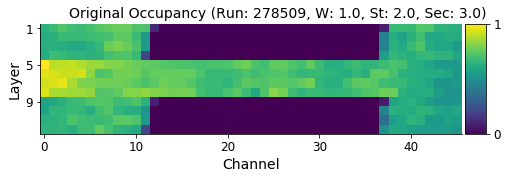

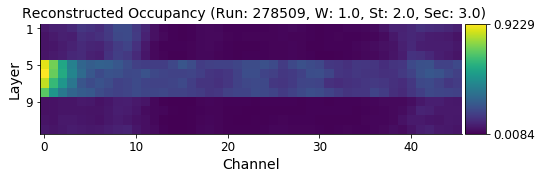

In [38]:
# The worst reconstruction
original_vs_reconstructed(drift_tubes_chambers.sort_values('score_Denoising', ascending=0).iloc[0])

## Evaluation

In [39]:
lines = [(color_palette["Indigo"][900], line_styles[0]),
         (color_palette["Teal"][600], line_styles[2]),
         (color_palette["Indigo"][400], line_styles[1]),
         (color_palette["Teal"][200], line_styles[0]),
         (color_palette["Indigo"][100], line_styles[0])]

In [40]:
df_test = drift_tubes_chambers[(drift_tubes_chambers["run"].isin(test_run)) &
                               (drift_tubes_chambers["station"] != 4)]

In [41]:
def layer_9_loss(column):
    """Returns MSE of layer 9"""
    losses = []
    for sample_loss in df_test["content_scaled"] - df_test[column]:
        losses.append(np.sum(abs(sample_loss), axis=1)[8])
    return losses

drift_tubes_chambers.loc[df_test.index, "score_Bottleneck_9"] = pd.DataFrame(
    {"score_Bottleneck_9": layer_9_loss("decoded_Bottleneck")}, index=df_test.index)
drift_tubes_chambers.loc[df_test.index, "score_Convolution_9"] = pd.DataFrame(
    {"score_Convolution_9": layer_9_loss("decoded_Convolution")}, index=df_test.index)
drift_tubes_chambers.loc[df_test.index, "score_Sparse_9"] = pd.DataFrame(
    {"score_Sparse_9": layer_9_loss("decoded_Sparse")}, index=df_test.index)
drift_tubes_chambers.loc[df_test.index, "score_Denoising_9"] = pd.DataFrame(
    {"score_Denoising_9": layer_9_loss("decoded_Denoising")}, index=df_test.index)

### Voltage fault

In [42]:
def get_roc_curve(test_df, models):
    """Generates ROC Curves for a given array"""
    fig, ax = plt.subplots()

    test_df = test_df[(test_df["score"] == 0)]
    
    for i, (legend_label, model_score) in enumerate(models):
        fpr, tpr, _ = roc_curve(test_df["voltage_fault"], test_df[model_score])
        auc_v = round(auc(fpr, tpr), 3)
        plt.plot(fpr,
                 tpr,
                 linewidth=3,
                 color=lines[i][0],
                 linestyle=lines[i][1],
                 label=("%s, AUC: %s" % (legend_label, auc_v)))

    plt.legend(frameon=False)
    plt.ylabel("Sensitivity (TPR)")
    plt.xlabel("Fall-out (TNR)")
    plt.xlim(0, 0.4)
    plt.ylim(0.6, 1)
    plt.show();

In [43]:
def error_distribution(score, bins_o):
    
    binBoundaries = np.linspace(min(test[score]), max(test[score]), bins_o)
    
    plt.figure()
    ax1 = plt.subplot(1, 1, 1)   
    ax1.hist([test[test.combined_score == -1][score].values,
              
              test[(test.voltage_fault == 1) &
                     (test.run == 302634)][score].values, # Voltage < 0.7
              
              test[(test.voltage_fault == 1) &
                     (test.run != 302634)][score].values], # Voltage > 0.7
             
              color=[color_palette["Teal"][200],
                     color_palette["Indigo"][900],
                     color_palette["Indigo"][200]],

              bins=binBoundaries,
              stacked=True,
              label=("Good", "Layer 9 at 3200V", "Layer 9 at 3450V"))

    ax1.set_ylabel("Chambers")
    plt.legend(frameon=False)
    plt.xlabel("MSE in layer 9")
    plt.subplots_adjust(hspace=0.9)
    plt.show()

In [44]:
test = drift_tubes_chambers[(drift_tubes_chambers["run"].isin(test_run)) &
                            (drift_tubes_chambers["station"] != 4)]
remove_incorrect_benchmarks = [9707, 9630, 9654]
test.drop(remove_incorrect_benchmarks, inplace=True)

/opt/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


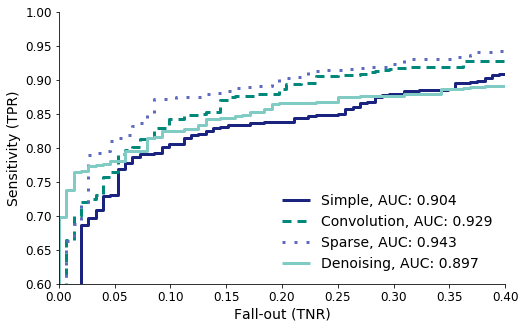

In [45]:
get_roc_curve(test,
              [("Simple", "score_Bottleneck_9"),
               ("Convolution", "score_Convolution_9"),
               ("Sparse", "score_Sparse_9"),
               ("Denoising", "score_Denoising_9")])

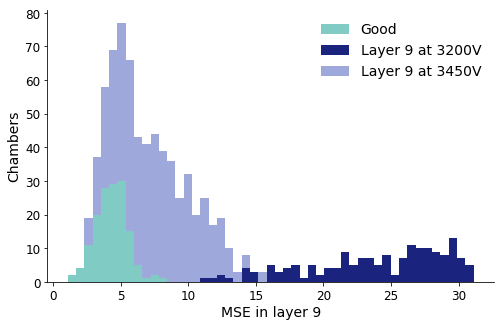

In [46]:
error_distribution("score_Sparse_9", 50)

### Faulty regions

In this model we hoped to catch all the chambers that were considered problematic by CNN plus some others that the CNN classifier did see as good since the additional information about the numerical relations between chambers and layers was removed. Hence, in a ROC Curve we are not as interested as the AUC but the fall-out rate for sensitivity close to 1.

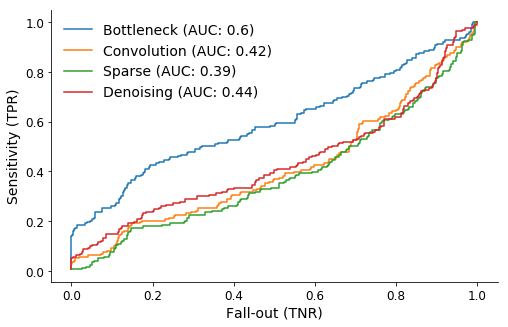

In [47]:
from sklearn.metrics import roc_curve, auc

df_test = drift_tubes_chambers[(drift_tubes_chambers["run"].isin(test_run)) &
                               (drift_tubes_chambers["station"] != 4)]

for autoencoder in autoencoders:
    column = "score_%s" % autoencoder
    
    fpr, tpr, _ = roc_curve(df_test["score"] > 0, df_test[column])
    
    title = "%s (AUC: %s)" % (autoencoder, round(auc(fpr, tpr), 2))
    
    plt.plot(fpr, tpr, label=title)

plt.ylabel("Sensitivity (TPR)")
plt.xlabel("Fall-out (TNR)")
plt.legend(frameon=False)

plt.show();

### Dimensionality reduction

In [169]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import LinearSegmentedColormap

In [170]:
def dimensionality_reduction(column, coloring, coordinates=None):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection="3d")
    
    if coordinates:
        evaluation = drift_tubes_chambers[(drift_tubes_chambers.wheel == coordinates[0]) &
                                          (drift_tubes_chambers.station == coordinates[1]) &
                                          (drift_tubes_chambers.sector == coordinates[2])]
    else:
        evaluation = drift_tubes_chambers[drift_tubes_chambers[column].notnull()]
        
    encoded = np.array([_ for _ in evaluation[column].values])

    plt.scatter(encoded[:, 0],
                encoded[:, 1],
                zs=encoded[:, 2],
                cmap=cmap,
                c=evaluation[coloring].values,
                alpha=0.9,
                s=30,
                marker="o")

    if coloring == "station":
        cbar = plt.colorbar(ticks=range(1, 4))
        cbar.ax.set_yticklabels(["Station 1", "Station 2", "Station 3"])
        
        title = "Latent layer for simple auto-encoder"
    else:
        cbar = plt.colorbar(ticks=range(13))
        cbar.ax.set_yticklabels(range(13))
        title = ("Latent layer across runs (W: %s, St: %s, Sec: %s)" %
                 (coordinates[0], coordinates[1], coordinates[2]))
        
    plt.title(title)
    ax.set_xlabel("Dimension 1")
    ax.set_ylabel("Dimension 2")
    ax.set_zlabel("Dimension 3")
    plt.show()

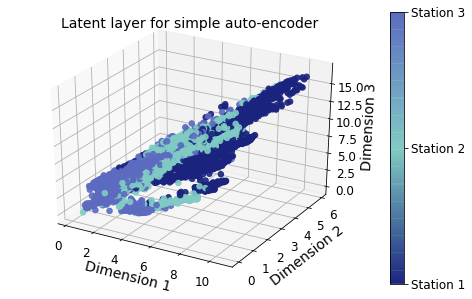

In [171]:
vmax = 2.0
cmap = LinearSegmentedColormap.from_list("foocmap", [(0 / vmax, color_palette["Indigo"][900]),
                                                     (1 / vmax, color_palette["Teal"][200]),
                                                     (2 / vmax, color_palette["Indigo"][400])])
dimensionality_reduction("encoded_Bottleneck", "station")

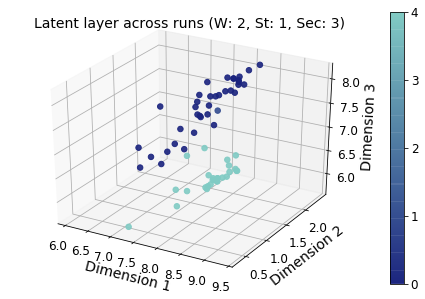

In [172]:
vmax = 1.0
cmap = LinearSegmentedColormap.from_list("foocmap", [(0 / vmax, color_palette["Indigo"][900]),
                                                     (1 / vmax, color_palette["Teal"][200])])

dimensionality_reduction("encoded_Bottleneck", "score", coordinates=[2,1,3])